# Final Project -  Finding the best Place in Toronto for a new grocery store


### Importing required libraries

In [19]:
import geocoder
import pandas as pd
import numpy as np
import requests

### Reading data from Wikipedia and cleaning it

In [20]:
link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
Wiki = requests.get(link)

wiki_data = pd.read_html(Wiki.content)[0]
df = wiki_data[wiki_data.Borough != 'Not assigned']
df.reset_index(inplace = True)
df.drop('index',axis=1,inplace = True)
grouped_df = df.groupby("Postal Code").agg({'Borough' : 'first','Neighbourhood' : ','.join})
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace = True)
ind=df['Neighbourhood'] == 'Not assigned'
df.loc[1,'Neighbourhood']=df.loc[1,'Borough']
df.head()


C:\Users\s.yazdanisangdeh\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\s.yazdanisangdeh\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
c:\users\s.yazdanisangdeh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,North York
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Adding latitude and longitude information to our data frame

In [21]:
dfNew = pd.read_csv("https://cocl.us/Geospatial_data")
df = df.join(dfNew.set_index('Postal Code'), on='Postal Code')
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,North York,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [22]:
import geocoder
from geopy.geocoders import Nominatim 

address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [23]:
import folium

# create map of Toronto using latitude and longitude values
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(toronto_map)  
    
toronto_map

### Requesting data from Foursquare

In [24]:
CLIENT_ID = 'FYJNBZPA13IUC0UZU5TOLD1VANJDMLXT4G5BUBLAY4HNQK1R' # your Foursquare ID
CLIENT_SECRET = 'JVYDFJ0M4OKVUQ3BG2XFFBPBZPS41S4Z435PUK0SSTFXEQBQ' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FYJNBZPA13IUC0UZU5TOLD1VANJDMLXT4G5BUBLAY4HNQK1R
CLIENT_SECRET:JVYDFJ0M4OKVUQ3BG2XFFBPBZPS41S4Z435PUK0SSTFXEQBQ


In [25]:
neigh_latitude = df.loc[0, 'Latitude'] 
neigh_longitude = df.loc[0, 'Longitude'] 

neighbourhood_name = df.loc[0, 'Neighbourhood'] 

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neigh_latitude, 
                                                               neigh_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [26]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neigh_latitude, 
    neigh_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=FYJNBZPA13IUC0UZU5TOLD1VANJDMLXT4G5BUBLAY4HNQK1R&client_secret=JVYDFJ0M4OKVUQ3BG2XFFBPBZPS41S4Z435PUK0SSTFXEQBQ&v=20180604&ll=43.7532586,-79.3296565&radius=500&limit=100'

In [27]:
results = requests.get(url).json()

In [28]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [29]:
import json
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Careful & Reliable Painting,Construction & Landscaping,43.752622,-79.331957
2,TTC stop #8380,Bus Stop,43.752672,-79.326351
3,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
toronto_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

North York
North York
Downtown Toronto
North York
Downtown Toronto
Etobicoke
Scarborough
North York
East York
Downtown Toronto
North York
Etobicoke
Scarborough
North York
East York
Downtown Toronto
York
Etobicoke
Scarborough
East Toronto
Downtown Toronto
York
Scarborough
East York
Downtown Toronto
Downtown Toronto
Scarborough
North York
North York
East York
Downtown Toronto
West Toronto
Scarborough
North York
North York
East York
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
North York
North York
Scarborough
North York
North York
East Toronto
North York
York
North York
Scarborough
North York
North York
Central Toronto
Central Toronto
York
York
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Etobicoke
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Mississauga
Etobicoke
Scarborough
Central Toronto
Downtown Toronto
West Toron

In [47]:
grocerydf=toronto_venues[toronto_venues['Venue Category'].str.contains("Grocery")]

### Applying k-means clustering to data

c:\users\s.yazdanisangdeh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\users\s.yazdanisangdeh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


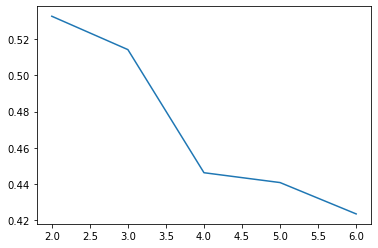

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
# set number of clusters

kclusters = 4
toronto_clustering=[]
grocerydf['Venue Latitude score'] = (grocerydf['Venue Latitude'] - grocerydf['Venue Latitude'].mean())/grocerydf['Venue Latitude'].std(ddof=0)
grocerydf['Venue Longitude score'] = (grocerydf['Venue Longitude'] - grocerydf['Venue Longitude'].mean())/grocerydf['Venue Longitude'].std(ddof=0)
toronto_clustering=grocerydf[['Venue Longitude score','Venue Latitude score']]
sil = []
kmax = 6

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(toronto_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_clustering, labels, metric = 'euclidean'))
plt.plot(range(2, kmax+1),sil)

In [49]:
kmeans = KMeans(n_clusters = 2).fit(toronto_clustering)
arr=kmeans.labels_
grocerydf['cluster'] = arr.tolist()


c:\users\s.yazdanisangdeh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(grocerydf['Venue Latitude'], grocerydf['Venue Longitude'],  grocerydf['cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        #popup=str(cluster-1)
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [51]:
grocerydf[['Borough', 'cluster']]

,Borough,cluster
287,Downtown Toronto,0
393,Downtown Toronto,0
425,East York,0
514,Downtown Toronto,0
521,Downtown Toronto,0
523,Downtown Toronto,0
529,Downtown Toronto,0
561,North York,1
573,East York,0
684,West Toronto,0
